Load V1 receptive fields from Ringach et. al. and compute covariance matrix

In [1]:
import numpy as np
import numpy.linalg as la
import glob
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
import h5py

In [2]:
dataroot = 'data/V1_data_Ringach/'
data = sio.loadmat(dataroot + 'rf_db.mat')['rf']
num_cells, dim = 250, 32 ** 2 # 250 cells with RF of size 32 x 32

In [3]:
# different cells have difference receptive field sizes (32 x 32, 64 x 64, 128 x 128). 
# Downsample them all to be 32 x 32.
STA = np.zeros((num_cells, dim))
time_to_peak = np.zeros(num_cells)
d2p = np.zeros(num_cells)

for cell in range(num_cells):
    s = data[0][cell][0]
    resize_factor = int(s.shape[0] / 32)
    s_scaled = downscale_local_mean(s, (resize_factor, resize_factor))
    STA[cell] = s_scaled.flatten()
    time_to_peak[cell] = data[0][cell][1]
    d2p[cell] = data[0][cell][2]

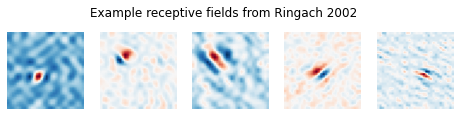

In [136]:
# pre-processing; z-score all the receptive fields
from skimage.measure import regionprops
STA = (STA - np.mean(STA, axis=1).reshape(-1, 1)) / np.std(STA, axis=1).reshape(-1, 1)

# plot a few receptive fields
fig = plt.figure(figsize=(8, 6))
plt.suptitle('Example receptive fields from Ringach 2002', y=0.65)
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    idx = np.random.randint(num_cells)
    plt.imshow(STA[idx].reshape(32, 32), cmap='RdBu')
    plt.axis('off')